# Data preparation

In [210]:
import numpy as np
import pandas as pd

## EDA

In [211]:
path = "Reviews.csv"

df = pd.read_csv(path)
print(df.shape)

(568454, 10)


In [212]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [213]:
df.describe(include = "all")

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
count,568454.000000,568454,568454,568428,568454.000000,568454.00000,568454.000000,5.684540e+05,568427,568454
unique,NaN,74258,256059,218415,NaN,NaN,NaN,NaN,295742,393579
top,NaN,B007JFMH8M,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",NaN,NaN,NaN,NaN,Delicious!,"This review will make me sound really stupid, ..."
freq,NaN,913,448,451,NaN,NaN,NaN,NaN,2462,199
mean,284227.500000,NaN,NaN,NaN,1.743817,2.22881,4.183199,1.296257e+09,NaN,NaN
std,164098.679298,NaN,NaN,NaN,7.636513,8.28974,1.310436,4.804331e+07,NaN,NaN
min,1.000000,NaN,NaN,NaN,0.000000,0.00000,1.000000,9.393408e+08,NaN,NaN
25%,142114.250000,NaN,NaN,NaN,0.000000,0.00000,4.000000,1.271290e+09,NaN,NaN
50%,284227.500000,NaN,NaN,NaN,0.000000,1.00000,5.000000,1.311120e+09,NaN,NaN
75%,426340.750000,NaN,NaN,NaN,2.000000,2.00000,5.000000,1.332720e+09,NaN,NaN


In [214]:
df.head(3)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [215]:
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
568449    False
568450    False
568451    False
568452    False
568453    False
Length: 568454, dtype: bool

In [216]:
df.isna().sum(axis=0)

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [217]:
df = df.dropna()

In [218]:
df.shape

(568401, 10)

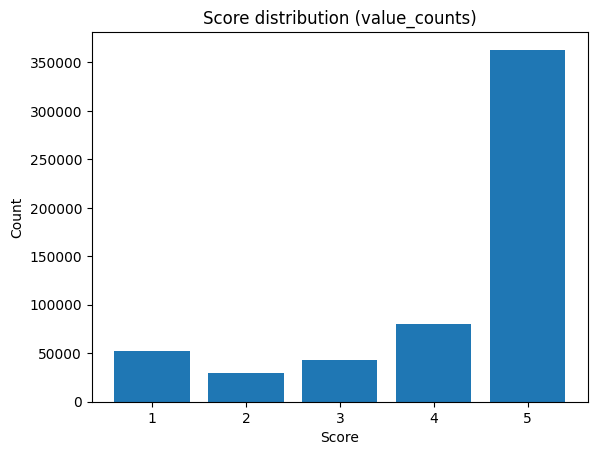

In [219]:
import matplotlib.pyplot as plt

counts = df['Score'].value_counts().sort_index()

plt.figure()
plt.bar(counts.index, counts.values)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Score distribution (value_counts)')
plt.show()

In [229]:
df["full_text"] = df["Summary"] + ". " + df["Text"] # because summary still contain valuable information

In [235]:
id_counts = df["UserId"].value_counts()
product_counts = df["ProductId"].value_counts()

df_filtered = df[(df["UserId"].map(id_counts) > 300) | (df["ProductId"].map(product_counts) > 300)]

In [236]:
df_filtered.shape

(56682, 11)

Rare users or products usually correspond to isolated reviews that cannot be meaningfully generalized, thus I filter them out.

In [237]:
df_filtered.to_csv("Reviews_clean.csv", index=False)

I decided to use the Kaggle Amazon Fine Food Reviews https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/data dataset for my project. It contains 568,454 rows and 10 columns. There are no duplicate rows, and only 53 rows contain missing values (NAs), so the dataset requires minimal cleaning. Although an LLM may already have prior knowledge of some products in this dataset (e.g., what TWIZZLERS are), it does not inherently know how people subjectively react to or evaluate them. Therefore, this dataset is suitable for a RAG setup that retrieves real user reviews as evidence. The Score column represents the user’s rating (1–5) and can serve as a target variable for downstream analysis. Notably, the score distribution is left-skewed.

# chunk and embedding

In [6]:
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
HF_TOKEN = os.getenv("HF_TOKEN")

In [1]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

C:\Users\chenk\Desktop\Genai\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 103/103 [00:00<00:00, 800.34it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


I also experimented with openai's text-embedding-3-small and found its performance to be comparable. However, with the consideration of cost efficiency and faster inference, I ultimately chose to stick with all-MiniLM-L6-v2.

In [34]:
avg_words = df["full_text"].str.split().str.len().mean()
print(avg_words)

84.38160383250558


In [62]:
df['ProductId'].value_counts()[df['ProductId'].value_counts() == 2]

ProductId
B00409O84Q    2
B0011B76HW    2
B003IEFDDE    2
B004MZ40DW    2
B004I613EE    2
             ..
B003SRWA7I    2
B0005XOT8Q    2
B002CNCAD8    2
B002FJTZZU    2
B001HTIES8    2
Name: count, Length: 12262, dtype: int64

I decide to use the first two to figure out which chunk method is the best.

In [60]:
df1 = df.loc[df["ProductId"].isin(["B00409O84Q", "B0011B76HW"])].copy()

In [88]:
df1["full_text"]

337638    Good to cut down on scooting. My dog is older ...
337639    Convenience over value. My dog has a sensitive...
480608    Pink's Hotdogs. I lived in the Los Angeles are...
480609    One of the best. Hoffy brand hot dogs "Hollywo...
Name: full_text, dtype: object

## Fixed-size chunking

In [190]:
def fixed_size_chunk(
    text,
    row_meta,
    chunk_size=50
):
    words = text.split()
    chunks = []

    for idx, i in enumerate(range(0, len(words), chunk_size)):
        chunk_text = " ".join(words[i:i+chunk_size])

        chunks.append({
            "Id": row_meta["Id"],
            "ProductId": row_meta["ProductId"],
            "UserId": row_meta["UserId"],
            "chunk_index": idx,
            "chunk_text": chunk_text
        })

    return chunks

In [191]:
chunk_fixed = []

for _, row in df1.iterrows():
    chunk_fixed.extend(
        fixed_size_chunk(
            text=row["full_text"],
            row_meta=row
        )
    )

In [192]:
df_chunks = pd.DataFrame(chunk_fixed)
df_chunks

,Id,ProductId,UserId,chunk_index,chunk_text
0,337639,B0011B76HW,A2NH9MW7BEHLSB,0,Good to cut down on scooting. My dog is older ...
1,337639,B0011B76HW,A2NH9MW7BEHLSB,1,is cheaper than taking her to the vet!!
2,337640,B0011B76HW,A1APPX7P3A9TGB,0,Convenience over value. My dog has a sensitive...
3,337640,B0011B76HW,A1APPX7P3A9TGB,1,for the shipping. That's why it's 4 stars rath...
4,480609,B00409O84Q,A2CG89FQCUKPR,0,Pink's Hotdogs. I lived in the Los Angeles are...
5,480609,B00409O84Q,A2CG89FQCUKPR,1,was no stopping me. Great Dog.
6,480610,B00409O84Q,A1O40QO2ITWELQ,0,"One of the best. Hoffy brand hot dogs ""Hollywo..."
7,480610,B00409O84Q,A1O40QO2ITWELQ,1,"Mild flavor, oversized, Hoffy's are sold in 12..."


In [193]:
texts = df_chunks["chunk_text"].tolist()

embeddings = model.encode(
    texts,
    normalize_embeddings=True,
    show_progress_bar=True
)

Batches: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


In [194]:
df_chunks["embedding"] = list(embeddings)

In [195]:
from sklearn.metrics.pairwise import cosine_similarity

embs = np.stack(df_chunks["embedding"].values)
sim_matrix = cosine_similarity(embs)
labels = [f"chunk_{i}" for i in range(8)]
df_sim = pd.DataFrame(sim_matrix, index=labels, columns=labels)
df_sim

,chunk_0,chunk_1,chunk_2,chunk_3,chunk_4,chunk_5,chunk_6,chunk_7
chunk_0,1.000000,0.355168,0.189083,-0.010461,0.187529,0.266229,0.151566,0.204118
chunk_1,0.355168,1.000000,0.346976,0.106123,0.262813,0.263485,0.182925,0.316460
chunk_2,0.189083,0.346976,1.000000,0.249368,0.280324,0.120270,0.202180,0.470572
chunk_3,-0.010461,0.106123,0.249368,1.000000,0.038052,0.096586,0.055966,0.168253
chunk_4,0.187529,0.262813,0.280324,0.038052,1.000000,0.245121,0.711777,0.531592
chunk_5,0.266229,0.263485,0.120270,0.096586,0.245121,1.000000,0.280239,0.175755
chunk_6,0.151566,0.182925,0.202180,0.055966,0.711777,0.280239,1.000000,0.522203
chunk_7,0.204118,0.316460,0.470572,0.168253,0.531592,0.175755,0.522203,1.000000


## Sentence-level chunking

In [196]:
import re

def sentence_chunk(text, row_meta):

    sentences = re.split(r'(?<=[.!?;])\s+', text)

    chunks = []

    for idx, sent in enumerate(sentences):
        sent = sent.strip()
        if not sent:
            continue

        chunks.append({
            "Id": row_meta["Id"],
            "ProductId": row_meta["ProductId"],
            "UserId": row_meta["UserId"],
            "chunk_index": idx,
            "chunk_text": sent
        })

    return chunks

In [197]:
chunk_sentence = []

for _, row in df1.iterrows():
    chunk_sentence.extend(
        sentence_chunk(
            text=row["full_text"],
            row_meta=row
        )
    )

In [198]:
df_chunks = pd.DataFrame(chunk_sentence)
df_chunks

,Id,ProductId,UserId,chunk_index,chunk_text
0,337639,B0011B76HW,A2NH9MW7BEHLSB,0,Good to cut down on scooting.
1,337639,B0011B76HW,A2NH9MW7BEHLSB,1,My dog is older and just recently started scoo...
2,337639,B0011B76HW,A2NH9MW7BEHLSB,2,She is a weighs about 45 lbs and I give her ju...
3,337639,B0011B76HW,A2NH9MW7BEHLSB,3,Good product.
4,337639,B0011B76HW,A2NH9MW7BEHLSB,4,It is cheaper than taking her to the vet!!
5,337640,B0011B76HW,A1APPX7P3A9TGB,0,Convenience over value.
6,337640,B0011B76HW,A1APPX7P3A9TGB,1,My dog has a sensitive digestive system so we ...
7,337640,B0011B76HW,A1APPX7P3A9TGB,2,My vets don't always have these in stock so it...
8,337640,B0011B76HW,A1APPX7P3A9TGB,3,They would even be a good deal if it wasn't fo...
9,337640,B0011B76HW,A1APPX7P3A9TGB,4,That's why it's 4 stars rather than 5.


In [199]:
texts = df_chunks["chunk_text"].tolist()

embeddings = model.encode(
    texts,
    normalize_embeddings=True,
    show_progress_bar=True
)

Batches: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


In [200]:
df_chunks["embedding"] = list(embeddings)

In [201]:
from sklearn.metrics.pairwise import cosine_similarity

embs = np.stack(df_chunks["embedding"].values)
sim_matrix = cosine_similarity(embs)
labels = [f"chunk_{i}" for i in range(18)]
df_sim = pd.DataFrame(sim_matrix, index=labels, columns=labels)
df_sim

,chunk_0,chunk_1,chunk_2,chunk_3,chunk_4,chunk_5,chunk_6,chunk_7,chunk_8,chunk_9,chunk_10,chunk_11,chunk_12,chunk_13,chunk_14,chunk_15,chunk_16,chunk_17
chunk_0,1.000000,0.131620,0.351290,0.207854,0.095996,0.157528,0.108399,-0.029968,0.058903,0.040499,0.161370,0.008219,-0.018186,0.113178,0.213936,0.249677,0.021841,0.008092
chunk_1,0.131620,1.000000,0.316206,0.043254,0.351315,-0.038646,0.275581,0.148523,-0.063023,-0.053798,-0.065281,0.178139,0.340175,0.338419,0.300110,0.011147,0.136074,0.117876
chunk_2,0.351290,0.316206,1.000000,0.015539,0.456959,0.005909,0.305856,0.183154,0.018625,-0.004132,0.013425,0.106369,0.165046,0.234070,0.172537,0.071727,0.049994,0.242781
chunk_3,0.207854,0.043254,0.015539,1.000000,0.142485,0.176427,0.097571,0.023164,0.077619,0.096254,-0.002107,0.123239,0.054630,0.073238,0.476345,0.329142,0.080525,0.130696
chunk_4,0.095996,0.351315,0.456959,0.142485,1.000000,0.150688,0.401683,0.391335,0.164425,0.058850,0.077977,0.236049,0.304004,0.319346,0.302376,0.169054,0.153957,0.313099
chunk_5,0.157528,-0.038646,0.005909,0.176427,0.150688,1.000000,0.055129,0.132448,0.168997,0.193382,0.185534,0.109543,0.070510,-0.017161,0.104357,0.127369,0.066806,0.124891
chunk_6,0.108399,0.275581,0.305856,0.097571,0.401683,0.055129,1.000000,0.345144,0.069502,-0.000948,0.024463,0.337838,0.275041,0.375271,0.319387,0.168914,0.198633,0.424056
chunk_7,-0.029968,0.148523,0.183154,0.023164,0.391335,0.132448,0.345144,1.000000,0.231848,0.158601,0.018881,0.202933,0.191221,0.290928,0.155766,0.057268,0.125975,0.420174
chunk_8,0.058903,-0.063023,0.018625,0.077619,0.164425,0.168997,0.069502,0.231848,1.000000,0.095764,0.162053,0.060128,0.107359,0.092998,0.014210,0.010896,0.079349,0.203167
chunk_9,0.040499,-0.053798,-0.004132,0.096254,0.058850,0.193382,-0.000948,0.158601,0.095764,1.000000,0.285165,0.060301,0.021134,-0.050779,0.046724,0.165246,0.037118,0.151816


## LangChain RecursiveTextSplitter

In [202]:
from langchain_text_splitters  import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=20
)

def langchain_chunk(
    text,
    row_meta,
    text_splitter
):
    chunks = []

    split_texts = text_splitter.split_text(text)

    for idx, chunk_text in enumerate(split_texts):
        chunks.append({
            "Id": row_meta["Id"],
            "ProductId": row_meta["ProductId"],
            "UserId": row_meta["UserId"],
            "chunk_index": idx,
            "chunk_text": chunk_text
        })

    return chunks

In [204]:
chunk_langchain = []

for _, row in df1.iterrows():
    chunk_langchain.extend(
        langchain_chunk(
            text=row["full_text"],
            row_meta=row,
            text_splitter=text_splitter
        )
    )


In [203]:
df_chunks = pd.DataFrame(chunk_langchain)
df_chunks

,Id,ProductId,UserId,chunk_index,chunk_text
0,337639,B0011B76HW,A2NH9MW7BEHLSB,0,Good to cut down on scooting. My dog is older ...
1,337639,B0011B76HW,A2NH9MW7BEHLSB,1,on the carpet. She is a weighs about 45 lbs a...
2,337639,B0011B76HW,A2NH9MW7BEHLSB,2,medium size bones twice a day with her food.<b...
3,337639,B0011B76HW,A2NH9MW7BEHLSB,3,product. It is cheaper than taking her to the...
4,337640,B0011B76HW,A1APPX7P3A9TGB,0,Convenience over value. My dog has a sensitive...
5,337640,B0011B76HW,A1APPX7P3A9TGB,1,having biscuits we can safely give her. My ve...
6,337640,B0011B76HW,A1APPX7P3A9TGB,2,in stock so it's convenient to order 2 or 3 ba...
7,337640,B0011B76HW,A1APPX7P3A9TGB,3,a good deal if it wasn't for the shipping. Th...
8,337640,B0011B76HW,A1APPX7P3A9TGB,4,5. It's too bad they're not eligible for supe...
9,480609,B00409O84Q,A2CG89FQCUKPR,0,Pink's Hotdogs. I lived in the Los Angeles are...


In [205]:
texts = df_chunks["chunk_text"].tolist()

embeddings = model.encode(
    texts,
    normalize_embeddings=True,
    show_progress_bar=True
)

Batches: 100%|██████████| 1/1 [00:00<00:00, 16.57it/s]


In [206]:
df_chunks["embedding"] = list(embeddings)

In [207]:
from sklearn.metrics.pairwise import cosine_similarity

embs = np.stack(df_chunks["embedding"].values)
sim_matrix = cosine_similarity(embs)
labels = [f"chunk_{i}" for i in range(17)]
df_sim = pd.DataFrame(sim_matrix, index=labels, columns=labels)
df_sim

,chunk_0,chunk_1,chunk_2,chunk_3,chunk_4,chunk_5,chunk_6,chunk_7,chunk_8,chunk_9,chunk_10,chunk_11,chunk_12,chunk_13,chunk_14,chunk_15,chunk_16
chunk_0,1.000000,0.407166,0.483043,0.337338,0.270284,0.266013,-0.055890,-0.038570,0.009370,0.178457,0.287127,0.205198,0.323554,0.159827,0.234335,0.205580,0.126030
chunk_1,0.407166,1.000000,0.496895,0.367246,0.134017,0.278034,0.043746,-0.062045,-0.004538,0.190333,0.217985,0.086551,0.123603,0.027107,0.008703,0.121277,0.144651
chunk_2,0.483043,0.496895,1.000000,0.441123,0.218129,0.390334,-0.008861,-0.003350,0.018905,0.109843,0.176671,0.194555,0.123269,0.090229,0.159975,0.084873,0.087013
chunk_3,0.337338,0.367246,0.441123,1.000000,0.418316,0.620047,0.089750,0.126505,-0.009539,0.303302,0.368580,0.269735,0.257288,0.271168,0.362071,0.241064,0.263237
chunk_4,0.270284,0.134017,0.218129,0.418316,1.000000,0.690315,0.209057,0.092648,0.052336,0.299836,0.313824,0.225730,0.202643,0.313625,0.474717,0.251441,0.353689
chunk_5,0.266013,0.278034,0.390334,0.620047,0.690315,1.000000,0.267770,0.123056,0.073614,0.293544,0.361147,0.318855,0.202770,0.261834,0.376402,0.239276,0.347453
chunk_6,-0.055890,0.043746,-0.008861,0.089750,0.209057,0.267770,1.000000,0.384467,0.123569,0.086757,0.047365,0.142057,-0.088484,0.043479,0.131148,0.077681,0.264181
chunk_7,-0.038570,-0.062045,-0.003350,0.126505,0.092648,0.123056,0.384467,1.000000,0.360887,0.031992,0.029448,0.055065,0.048704,0.064298,0.024696,0.072849,0.203210
chunk_8,0.009370,-0.004538,0.018905,-0.009539,0.052336,0.073614,0.123569,0.360887,1.000000,-0.021922,-0.051090,0.076571,0.066676,-0.009184,0.064192,0.097589,0.168917
chunk_9,0.178457,0.190333,0.109843,0.303302,0.299836,0.293544,0.086757,0.031992,-0.021922,1.000000,0.694725,0.331616,0.249327,0.484026,0.352927,0.633700,0.501547


RecursiveCharacterTextSplitter (configured with chunk_size=100 and chunk_overlap=20) performs better than the other chunking strategies discussed in class. Based on the cosine similarity matrix, it produces chunks that are more semantically consistent, as evidenced by higher cosine similarity both between different chunks from the same review row and across chunks from reviews of the same product.